In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Stimulus-driven predictive model of brain activity.
What we will need:
- "imagenet_trained_model_weights.pkl"
- The betas and experiment stimuli
- A brain mask

In [2]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fpX = np.float32
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict

import torch as T
import torch.nn as L
import torch.nn.init as I
import torch.nn.functional as F
import torch.optim as optim

In [3]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 3
device#: 0
device name: TITAN RTX

torch: 1.3.0
cuda:  10.1.243
cudnn: 7603
dtype: torch.float32


In [4]:
sns.axes_style()
sns.set_style("whitegrid", {"axes.facecolor": '.95'})
sns.set_context("notebook", rc={'axes.labelsize': 18.0, 'axes.titlesize': 24.0, 'legend.fontsize': 18.0, 'xtick.labelsize': 18.0, 'ytick.labelsize': 18.0})
sns.set_palette("deep")

In [5]:
trn_subjects = [1,2,3,4,5,6,7,8]# 2, 5, 6]

In [6]:
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) # 'Aug-10-2020_1638' #

model_name = 'gnet_mpf' #'gnet_mpf_general'
model_dir = '%s_%s' % (model_name, timestamp)

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/"
output_dir = root_dir+"output/multisubject/%s_%s/" % (model_name,timestamp) 
video_dir = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)   
print ("Time Stamp: %s" % timestamp)

Time Stamp: Feb-19-2021_1346


# Load the stimuli images
From the subjectwise image preparation

In [7]:
nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"

In [8]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

In [9]:
image_data = {}
for s in trn_subjects: 
    image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%s, 'r')
    image_data[s] = np.copy(image_data_set['stimuli'])
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
           np.min(image_data[s][0]), np.max(image_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 2  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 3  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 4  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 5  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 6  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 7  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 8  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


## Examples

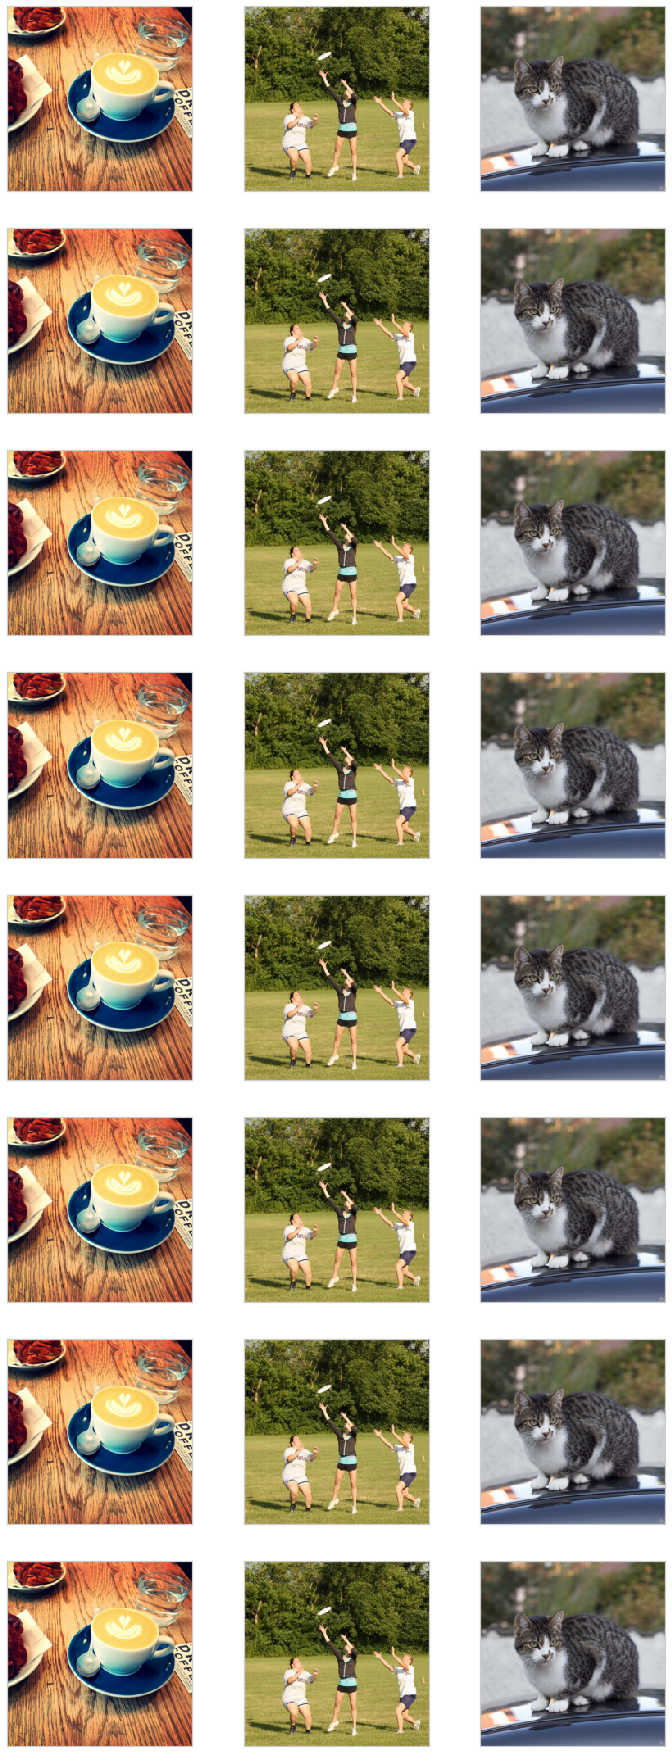

In [10]:
n = 6
plt.figure(figsize=(12,4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(image_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [11]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [12]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

brain_nii_shape, voxel_mask, voxel_idx, voxel_roi, voxel_ncsnr = {}, {}, {}, {}, {}

for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)
    #voxel_mask_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)
    voxel_roi_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    #ncsnr_full = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%s)
    ###
    brain_nii_shape[s] = voxel_roi_full.shape
    print (brain_nii_shape[s])
    ###
    voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
    voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
    ###
    voxel_mask[s]  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
    voxel_idx[s]   = np.arange(len(voxel_mask[s]))[voxel_mask[s]]
    voxel_roi[s]   = voxel_joined_roi_full[voxel_mask[s]]
    #voxel_ncsnr[s] = ncsnr_full.flatten()[voxel_mask[s]]
        
    print ('full mask length = %d'%len(voxel_mask[s]))
    print ('selection length = %d'%np.sum(voxel_mask[s]))
    
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names):
        print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

--------  subject 1  -------
(81, 104, 83)
full mask length = 699192
selection length = 4627
1348 	: V1
1415 	: V2
1188 	: V3
676 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other
--------  subject 2  -------
(82, 106, 84)
full mask length = 730128
selection length = 3765
1097 	: V1
1083 	: V2
1081 	: V3
504 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other
--------  subject 3  -------
(81, 106, 82)
full mask length = 704052
selection length = 3778
1251 	: V1
1160 	: V2
945 	: V3
422 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other
--------  subject 4  -------
(85, 99, 80)
full mask length = 673200
selection length = 3027
871 	: V1
883 	: V2
800 	: V3
473 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other
--------  subject 5  -------
(79, 97, 78)
full mask length = 597714
selection length = 3685
1115 	: V1
1088 	: V2
934 	: V3
548 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO

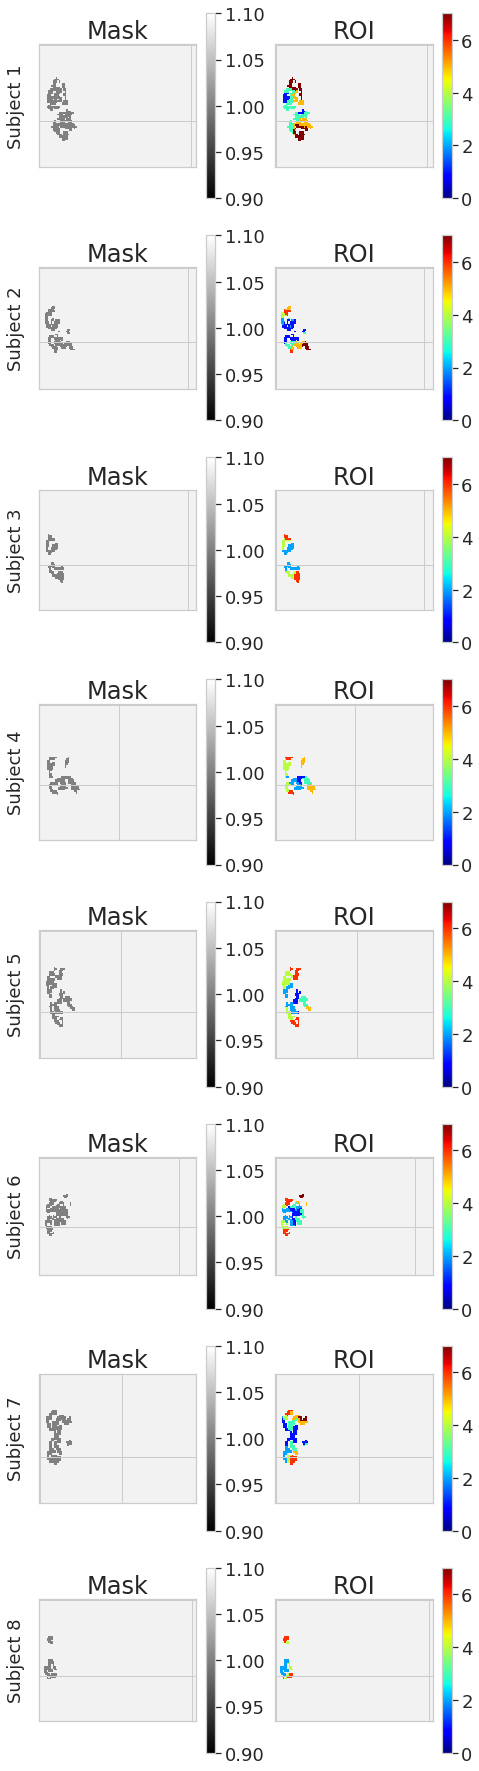

In [13]:
slice_idx = 35
plt.figure(figsize=(12, 4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    
    volume_brain_mask = view_data(brain_nii_shape[s], voxel_idx[s], np.ones_like(voxel_idx[s]), save_to=subject_dir+"subj%02d_mask"%s)
    volume_brain_roi  = view_data(brain_nii_shape[s], voxel_idx[s], voxel_roi[s], save_to=subject_dir+"subj%02d_roi"%s)
    #volume_ncsnr      = view_data(brain_nii_shape[s], voxel_idx[s], voxel_ncsnr[s], save_to=subject_dir+"subj%02d_ncsnr"%s) 
    ##
    plt.subplot(len(trn_subjects),3,3*k+1)
    plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
    plt.title('Mask')
    plt.colorbar()
    _=plt.ylabel('Subject %d'%s)
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+2)
    plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
    plt.clim([0,7])
    plt.title('ROI')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    #plt.subplot(len(trn_subjects),3,3*k+3)
    #plt.imshow(volume_ncsnr[:,:,slice_idx], cmap='hot', interpolation='None')
    #plt.title('NCSNR')
    #plt.colorbar()
    #_=plt.gca().set_xticklabels([])
    #_=plt.gca().set_yticklabels([])

# Load voxels
Only run one of these cells
## Quick load (Load the voxel data block for these voxels only)

In [14]:
voxel_data_set = h5py.File(root_dir+'voxel_data_V1_4_part1.h5py', 'r')
#voxel_data_set = h5py.File(root_dir+'voxel_data_general.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()

voxel_data_1 = voxel_data_dict['voxel_data']
print (voxel_data_1.keys())

dict_keys(['1', '2', '5', '6'])


In [15]:
voxel_data_set = h5py.File(root_dir+'voxel_data_V1_4_part2.h5py', 'r')
#voxel_data_set = h5py.File(root_dir+'voxel_data_general.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()

voxel_data_2 = voxel_data_dict['voxel_data']
print (voxel_data_2.keys())

dict_keys(['3', '4', '7', '8'])


In [16]:
voxel_data_1.update(voxel_data_2)
print (voxel_data_1.keys())

dict_keys(['1', '2', '5', '6', '3', '4', '7', '8'])


In [18]:
voxel_data = {}
for s in trn_subjects:
    roi_masks = list(iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names))
    roi_mask, roi_name = roi_masks[2]
    voxel_data['%s'%s] = voxel_data_1['%s'%s][:,roi_mask]
    print ("%s: %d \t: %s" % (s, np.sum(roi_mask), roi_name))

1: 1188 	: V3
2: 1081 	: V3
3: 945 	: V3
4: 800 	: V3
5: 934 	: V3
6: 1215 	: V3
7: 721 	: V3
8: 879 	: V3


In [19]:
del voxel_data_1
del voxel_data_2

## Slow load from raw data

In [18]:
**
## Long version
from src.load_nsd import load_betas

voxel_data = {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/"%s
    voxel_data[s],_ = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask[s], up_to=-1)
    print ('----------------------------')
    print (voxel_data[s].shape)
    
save_stuff(root_dir + 'voxel_data_general', 
    flatten_dict({
   'voxel_mask': voxel_mask,
   'voxel_roi': voxel_roi,
   'voxel_idx': voxel_idx,
   'voxel_ncsnr': voxel_ncsnr,
   'voxel_data': voxel_data
            }))

SyntaxError: invalid syntax (<ipython-input-18-df5e723635cf>, line 1)

# Dataset split and unpacking or averaging
## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.

In [20]:
from src.load_nsd import image_feature_fn, data_split

data_size, nnv = {}, {}
trn_stim_data, trn_voxel_data  = {}, {}
val_stim_single_trial_data, val_voxel_single_trial_data = {}, {}
val_stim_multi_trial_data, val_voxel_multi_trial_data = {}, {}

for k,s in enumerate(trn_subjects):
    data_size[s], nnv[s] = voxel_data['%s'%s].shape 
    print ('--------  subject %d  -------' % s)
    trn_stim_data[s], trn_voxel_data[s],\
    val_stim_single_trial_data[s], val_voxel_single_trial_data[s],\
    val_stim_multi_trial_data[s], val_voxel_multi_trial_data[s] = \
        data_split(image_feature_fn(image_data[s]), voxel_data['%s'%s], ordering, imagewise=False)

--------  subject 1  -------
Total number of voxels = 1188
--------  subject 2  -------
Total number of voxels = 1081
--------  subject 3  -------
Total number of voxels = 945
--------  subject 4  -------
Total number of voxels = 800
--------  subject 5  -------
Total number of voxels = 934
--------  subject 6  -------
Total number of voxels = 1215
--------  subject 7  -------
Total number of voxels = 721
--------  subject 8  -------
Total number of voxels = 879


- "stim_data" includes stimuli repeat. Takes more memory but it is easier to align with the single-trial voxel activity.

In [21]:
del voxel_data
del image_data

In [22]:
trn_stim_mean = sum([np.mean(trn_stim_data[s], axis=(0,2,3), keepdims=True) for s in trn_subjects])/len(trn_subjects)
print (trn_stim_mean)

[[[[0.4750554 ]]

  [[0.45152923]]

  [[0.41182032]]]]


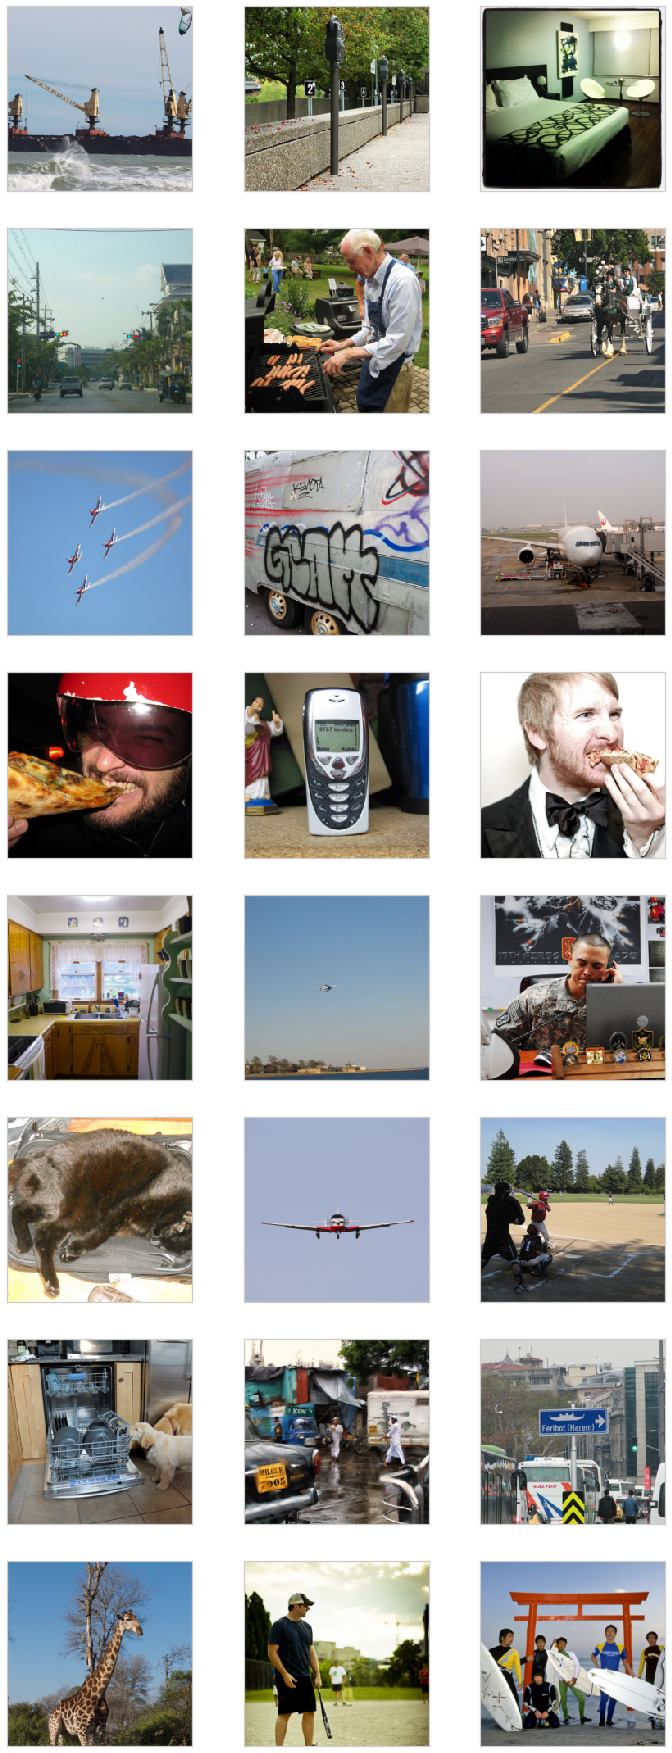

In [23]:
n = 6
plt.figure(figsize=(12,4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(trn_stim_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

---
# Model

In [24]:
import src.torch_joint_training_sequences as aaa
import imp
imp.reload(aaa)

<module 'src.torch_joint_training_sequences' from '/home/styvesg/Documents/PostDoc/GitRepo/nsd/src/torch_joint_training_sequences.py'>

In [25]:
from src.torch_joint_training_sequences import *
from src.torch_gnet import Encoder
from src.torch_mpf import Torch_LayerwiseFWRF

## Model instanciation

In [26]:
_log_act_fn = lambda _x: T.log(1 + T.abs(_x))*T.tanh(T.abs(_x))

In [27]:
shared_model = Encoder(trn_stim_mean, trunk_width=64).to(device)
rec, fmaps, h = shared_model(T.from_numpy(trn_stim_data[trn_subjects[0]][:20]).to(device))

subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=nnv[s], pre_nl=_log_act_fn, \
                 post_nl=_log_act_fn, dtype=np.float32).to(device) for s in trn_subjects}

## Parameter count

In [28]:
for s,sp in subject_fwrfs.items():
    print ("--------- subject %d ----------"%s)
    for p in sp.parameters():
        print ("block size %-16s" % (list(p.size())))
        
param_count = 0
for w in shared_model.enc.parameters():
    param_count += np.prod(tuple(w.size()))
print ('')
print (param_count, "shared params")
total_nv = 0
for s,sp in subject_fwrfs.items():
    for p in sp.parameters():
        param_count += np.prod(tuple(p.size()))
    total_nv += nnv[s]
print (param_count // total_nv, "approx params per voxels")

--------- subject 1 ----------
block size [1188, 25, 25]  
block size [1188, 13, 13]  
block size [1188, 512]     
block size [1188]          
--------- subject 2 ----------
block size [1081, 25, 25]  
block size [1081, 13, 13]  
block size [1081, 512]     
block size [1081]          
--------- subject 3 ----------
block size [945, 25, 25]   
block size [945, 13, 13]   
block size [945, 512]      
block size [945]           
--------- subject 4 ----------
block size [800, 25, 25]   
block size [800, 13, 13]   
block size [800, 512]      
block size [800]           
--------- subject 5 ----------
block size [934, 25, 25]   
block size [934, 13, 13]   
block size [934, 512]      
block size [934]           
--------- subject 6 ----------
block size [1215, 25, 25]  
block size [1215, 13, 13]  
block size [1215, 512]     
block size [1215]          
--------- subject 7 ----------
block size [721, 25, 25]   
block size [721, 13, 13]   
block size [721, 512]      
block size [721]           

## Load prefilters value

In [29]:
try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
    
state_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', progress=True)
        ### Rename dictionary keys to match new breakdown
pre_state_dict = {}
pre_state_dict['conv1.0.weight'] = state_dict.pop('features.0.weight')
pre_state_dict['conv1.0.bias'] = state_dict.pop('features.0.bias')
pre_state_dict['conv2.0.weight'] = state_dict.pop('features.3.weight')
pre_state_dict['conv2.0.bias'] = state_dict.pop('features.3.bias')
  
    
shared_model.pre.load_state_dict(pre_state_dict)
#for s,m in subject_models.items():
#    m.pre.load_state_dict(pre_state_dict)

<All keys matched successfully>

# Loss function, grad function, etc.

In [30]:
optimizer_net = optim.Adam([
        #{'params': shared_model.pre.parameters()},
        {'params': shared_model.enc.parameters()},
    ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08)

subject_optimizer = {s: optim.Adam([
        {'params': sp.parameters()}
    ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}

subject_opts = {s: [optimizer_net, subject_optimizer[s]] for s in subject_optimizer.keys()}

In [31]:
def _model_fn(_ext, _con, _x):
    '''model consists of an extractor (_ext) and a connection model (_con)'''
    _y, _fm, _h = _ext(_x)
    return _con(_fm)

def _smoothness_loss_fn(_rf, n):
    delta_x = T.sum(T.pow(T.abs(_rf[:, 1:]    - _rf[:, :-1]), n))
    delta_y = T.sum(T.pow(T.abs(_rf[:, :, 1:] - _rf[:, :, :-1]), n))
    return delta_x + delta_y

def _loss_fn(_ext, _con, _x, _v):
    _r = _model_fn(_ext, _con, _x)
    _err = T.sum((_r - _v)**2, dim=0)
    _loss = T.sum(_err)
    _loss += fpX(1e-1) * T.sum(T.abs(_con.w))
    return _err, _loss
    
def _training_fn(_ext, _con, _opts, xb, yb):
    for _opt in _opts:
        _opt.zero_grad()
        _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
        _loss.backward()
        _opt.step()
    return _err

def _holdout_fn(_ext, _con, xb, yb):
    _err,_ = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
    return _err

def _pred_fn(_ext, _con, xb):
    return _model_fn(_ext, _con, T.from_numpy(xb).to(device))

def print_grads(_ext, _con, _params, _opt, xb, yb):
    _opt.zero_grad()
    _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))  
    _loss.backward()   
    for p in _params:
        prg = get_value(p.grad)     
        print ("%-16s : value=%f, grad=%f" % (list(p.size()), np.mean(np.abs(get_value(p))), np.mean(np.abs(prg))))
    print ('--------------------------------------')
    sys.stdout.flush()

In [ ]:
subj = trn_subjects[0]
print_grads(shared_model, subject_fwrfs[subj],
            shared_model.enc.parameters(), 
            subject_optimizer[subj],
            trn_stim_data[subj][:20],
            trn_voxel_data[subj][:20])
print_grads(shared_model, subject_fwrfs[subj],
            subject_fwrfs[subj].parameters(), 
            subject_optimizer[subj],
            trn_stim_data[subj][:20],
            trn_voxel_data[subj][:20])

[128, 192, 3, 3] : value=0.029672, grad=0.026486
[128]            : value=0.000000, grad=0.082641
[192]            : value=1.000000, grad=0.038011
[192]            : value=0.000000, grad=0.126875
[128, 128, 3, 3] : value=0.033198, grad=0.023413
[128]            : value=0.000000, grad=0.033259
[128]            : value=1.000000, grad=0.037997
[128]            : value=0.000000, grad=0.076075
[128, 128, 3, 3] : value=0.033277, grad=0.022359
[128]            : value=0.000000, grad=0.036447
[128]            : value=1.000000, grad=0.035217
[128]            : value=0.000000, grad=0.078117
[128, 128, 3, 3] : value=0.033304, grad=0.014543
[128]            : value=0.000000, grad=0.040060
[128]            : value=1.000000, grad=0.022276
[128]            : value=0.000000, grad=0.079986
[128, 128, 3, 3] : value=0.033185, grad=0.021268
[128]            : value=0.000000, grad=0.039517
[128]            : value=1.000000, grad=0.032471
[128]            : value=0.000000, grad=0.098984
[128, 128, 3, 3] : v

# Training
IDEA: Use the more stable estimate from the holdout val cc to weight the voxels
Use a contiguity cost instead of sparsity for RF weights

In [ ]:
batch_size = 100
num_epochs = 50
holdout_size = 3000

best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
    learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
        trn_stim_data, trn_voxel_data,
        num_epochs=num_epochs, batch_size=batch_size, holdout_size=holdout_size, masks=None, randomize=False)

\ : 100.0 %
  Epoch 1 of 50 took       282.980s
  training loss:               0.979352
  holdout loss (batch):        0.970180
  Subject 1: median (max) validation accuracy = 0.150 (0.427)
  Subject 2: median (max) validation accuracy = 0.176 (0.473)
  Subject 3: median (max) validation accuracy = 0.154 (0.395)
  Subject 4: median (max) validation accuracy = 0.146 (0.382)
  Subject 5: median (max) validation accuracy = 0.153 (0.475)
  Subject 6: median (max) validation accuracy = 0.158 (0.448)
  Subject 7: median (max) validation accuracy = 0.117 (0.332)
  Subject 8: median (max) validation accuracy = 0.158 (0.419)
** Saving params with joint score = 0.152 **

\ : 100.0 %
  Epoch 2 of 50 took       264.056s
  training loss:               0.968107
  holdout loss (batch):        0.963195
  Subject 1: median (max) validation accuracy = 0.171 (0.478)
  Subject 2: median (max) validation accuracy = 0.198 (0.505)
  Subject 3: median (max) validation accuracy = 0.165 (0.417)
  Subject 4: med

  Subject 2: median (max) validation accuracy = 0.318 (0.664)
  Subject 3: median (max) validation accuracy = 0.207 (0.456)
  Subject 4: median (max) validation accuracy = 0.214 (0.508)
  Subject 5: median (max) validation accuracy = 0.202 (0.540)
  Subject 6: median (max) validation accuracy = 0.234 (0.562)
  Subject 7: median (max) validation accuracy = 0.142 (0.397)
  Subject 8: median (max) validation accuracy = 0.186 (0.469)
** Saving params with joint score = 0.218 **

\ : 100.0 %
  Epoch 14 of 50 took       250.402s
  training loss:               0.924894
  holdout loss (batch):        0.934743
  Subject 1: median (max) validation accuracy = 0.299 (0.621)
  Subject 2: median (max) validation accuracy = 0.322 (0.665)
  Subject 3: median (max) validation accuracy = 0.209 (0.457)
  Subject 4: median (max) validation accuracy = 0.214 (0.505)
  Subject 5: median (max) validation accuracy = 0.204 (0.544)
  Subject 6: median (max) validation accuracy = 0.237 (0.563)
  Subject 7: median

# Results

In [ ]:
plt.figure(figsize=(24,3))
plt.plot(trn_hist, color='r', marker='o', ms=10, lw=2)
plt.plot(np.array(hold_hist), color='b', marker='o', ms=10, lw=2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()

In [ ]:
plt.figure(figsize=(24,6))
plt.subplot(2,1,1)
for s,cc in hold_cc_hist.items():
    plt.gca().violinplot(np.nan_to_num(np.array(cc)).T, showmeans=True, showmedians=True, showextrema=True)
plt.ylabel('Validation history')
plt.subplot(2,1,2)
for s in hold_cc_hist.keys():
    p=plt.plot([np.median(cc) for cc in hold_cc_hist[s]], lw=2, linestyle='--')
plt.legend()
plt.ylabel('Median history')
plt.xlabel('epoch')

---
## Final validation accuracy

In [ ]:
val_voxel = {s: val_voxel_single_trial_data[s] for s in val_voxel_single_trial_data.keys()}
shared_model.load_state_dict(best_params['enc'])
shared_model.eval() 
for s,sd in subject_fwrfs.items():
    sd.load_state_dict(best_params['fwrfs'][s])
    sd.eval() 

batch_size = 50
subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, val_stim_single_trial_data, val_voxel, batch_size)
joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)

In [ ]:
print ("best joint score = %.3f"%best_joint_cc_score)
print ("best joint val cc = %.3f"% np.median(joined_val_cc))
for s,v in subject_val_cc.items():
    print ("subject %s: val cc = %.3f"%(s, np.median(v)))

fig=plt.figure(figsize=(12,4))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(joined_val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.1, 0.9])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

# Save final parameters

In [ ]:
torch.save({
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'holdout_size': holdout_size,   
            'best_params': best_params, 
            'final_params': final_params,
            'trn_loss_history': trn_hist,
            'hold_loss_history': hold_hist,
            'hold_cc_history': hold_cc_hist,
            'best_epoch': best_epoch,
            'best_joint_cc_score': best_joint_cc_score,
            'val_cc': subject_val_cc,
            'voxel_index': voxel_idx,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask
            }, output_dir+'model_params')

In [ ]:
f = open(output_dir+'model_notes.txt', "w+")
f.write( "Run on V3 for a 8 subjects\n")
f.close()

In [47]:
n_resample = 64
subject_resample_val_cc = {}

for s in val_voxel_single_trial_data.keys():
    print ('sampling subject %d'%s)
    subject_resample_val_cc[s] = cc_resampling_with_replacement(_pred_fn, shared_model, subject_fwrfs[s], val_stim_single_trial_data[s], val_voxel_single_trial_data[s], batch_size, n_resample)

sampling subject 1


100%|██████████| 64/64 [00:06<00:00, 10.24it/s]


sampling subject 2


100%|██████████| 64/64 [00:04<00:00, 13.77it/s]


sampling subject 3


100%|██████████| 64/64 [00:03<00:00, 17.37it/s]


sampling subject 4


100%|██████████| 64/64 [00:04<00:00, 15.52it/s]


sampling subject 5


100%|██████████| 64/64 [00:05<00:00, 12.51it/s]


sampling subject 6


100%|██████████| 64/64 [00:04<00:00, 14.56it/s]


sampling subject 7


100%|██████████| 64/64 [00:03<00:00, 18.06it/s]


sampling subject 8


100%|██████████| 64/64 [00:04<00:00, 14.91it/s]


best_joint_cc_score: 0.216
score mean = 0.2324, std.dev = 0.0023
Subject 1 median cc mean = 0.2679, std.dev = 0.0046
Subject 2 median cc mean = 0.3461, std.dev = 0.0055
Subject 3 median cc mean = 0.2328, std.dev = 0.0070
Subject 4 median cc mean = 0.1998, std.dev = 0.0066
Subject 5 median cc mean = 0.2577, std.dev = 0.0057
Subject 6 median cc mean = 0.1953, std.dev = 0.0057
Subject 7 median cc mean = 0.1925, std.dev = 0.0065
Subject 8 median cc mean = 0.2122, std.dev = 0.0082


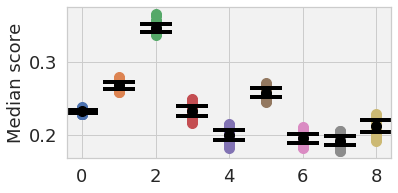

In [49]:
f = open(output_dir+'model_notes.txt', "w")
f.write( "-- median_validation_accuracies --\n")

print ('best_joint_cc_score: %.3f' % best_joint_cc_score)
fig=plt.figure(figsize=(6,6))
plt.subplots_adjust(left=0.2, bottom=0.60, right=.95, top=.95, wspace=0., hspace=0.)
val_score_samples = [np.median(np.concatenate([ccs[i] for s,ccs in subject_resample_val_cc.items()], axis=0))\
    for i in range(n_resample)]
print ('score mean = %.04f, std.dev = %.04f'% (np.mean(val_score_samples),  np.std(val_score_samples)))
f.write('score mean = %.04f, std.dev = %.04f\n'% (np.mean(val_score_samples),  np.std(val_score_samples)))
plt.plot([0,]*len(val_score_samples), val_score_samples, linestyle='None', marker='o', ms=10)
plt.errorbar(x=[0,], y=[np.mean(val_score_samples),], yerr=[np.std(val_score_samples),], marker='o',\
    color='k', ms=10, elinewidth=4,capsize=16, capthick=4)

for k,(s,ccs) in enumerate(subject_resample_val_cc.items()): 
    mcc = [np.median(cc) for cc in ccs]
    print ('Subject %s median cc mean = %.04f, std.dev = %.04f'% (s, np.mean(mcc), np.std(mcc)))
    f.write('Subject %s median cc mean = %.04f, std.dev = %.04f\n'% (s, np.mean(mcc), np.std(mcc)))
    plt.plot([k+1,]*len(mcc), mcc, linestyle='None', marker='o', ms=10)
    plt.errorbar(x=[k+1,], y=[np.mean(mcc),], yerr=[np.std(mcc),], marker='o',\
             color='k', ms=10, elinewidth=4,capsize=16, capthick=4)
    plt.ylabel('Median score') 
f.close()

In [50]:
filename = output_dir + 'median_validation_accuracies%s'  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

# Subject-wise analysis

In [51]:
subj = 1 # for s in val_subjects
subject_dir = output_dir + 'S%02d/'%subj

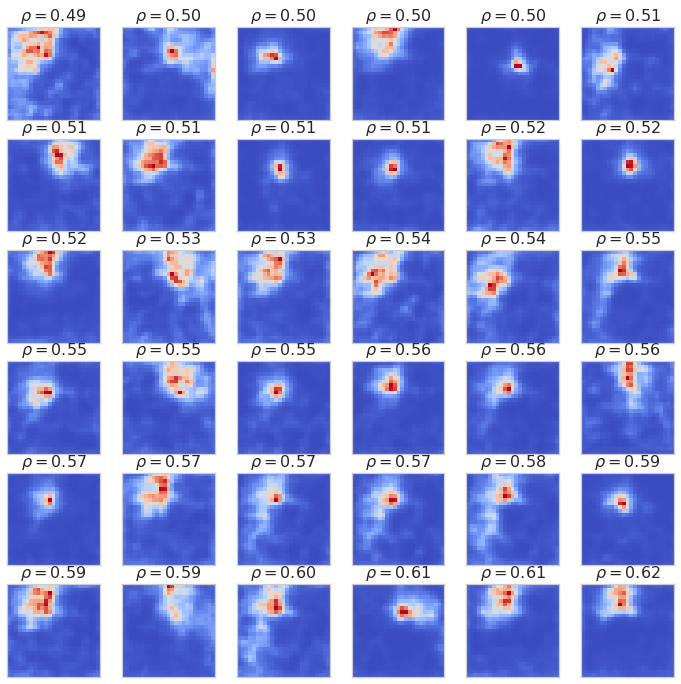

In [52]:
from matplotlib import cm
def pooling_fn(x):
    return np.exp(x) / np.sum(np.exp(x), axis=(1,2), keepdims=True)

vidxes = np.argsort(subject_val_cc[subj])
vox = vidxes[-36:] # np.arange(49) #
n_x = int(np.floor(np.sqrt(len(vox))))
n_y = int(np.ceil(len(vox)/n_x))+1
fig2a=plt.figure(figsize=(2*n_x,2*n_y))
for k,v in enumerate(vox):
    plt.subplot(n_y,n_x,k+1)
    plt.imshow(pooling_fn(get_value(subject_fwrfs[subj].rfs[0])[v,np.newaxis])[0], interpolation='None', cmap=cm.coolwarm, origin='upper') # vidxes[-100:]  
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title(r'$\rho=$%.2f'% subject_val_cc[subj][v], fontsize=16)

In [53]:
filename = output_dir + 'S%02d/subj%02d_rf0_sample%s'  % (subj , subj, saveext)
fig2a.patch.set_alpha(0.)
fig2a.savefig(filename, **savearg)
plt.close()

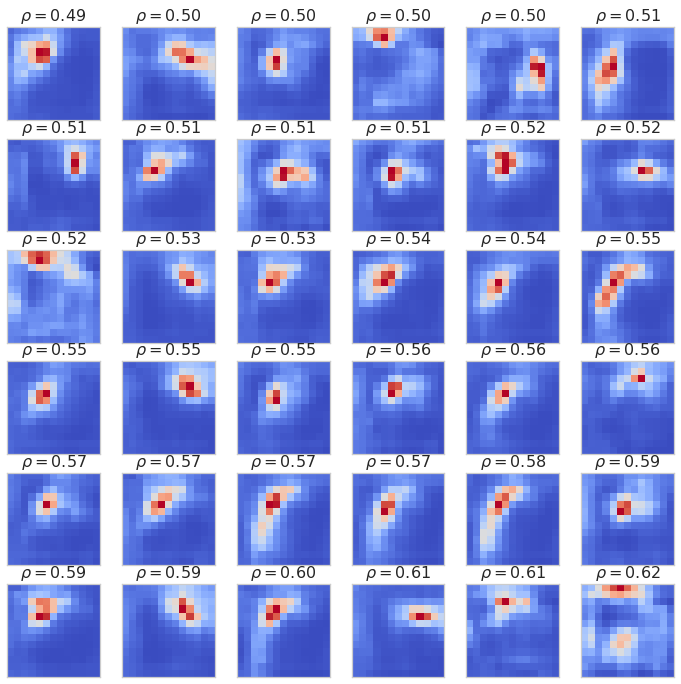

In [54]:
fig2b=plt.figure(figsize=(2*n_x,2*n_y))
for k,v in enumerate(vox):
    plt.subplot(n_y,n_x,k+1)
    plt.imshow(pooling_fn(get_value(subject_fwrfs[subj].rfs[1])[v,np.newaxis])[0], interpolation='None', cmap=cm.coolwarm, origin='upper') # vidxes[-100:]  
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  
    plt.title(r'$\rho=$%.2f'% subject_val_cc[subj][v], fontsize=16)

In [55]:
filename = output_dir + 'S%02d/subj%02d_rf1_sample%s'  % (subj , subj, saveext)
fig2b.patch.set_alpha(0.)
fig2b.savefig(filename, **savearg)
plt.close()

---
# Compare to other models

In [72]:
file_timestamp_dir = {# the classic dnn-fwrf folders
    1: "Mar-27-2020_0301",
    2: "Apr-01-2020_0250",
    3: "Apr-25-2020_1550",
    4: "May-08-2020_2148",    
    5: "Mar-29-2020_2349",
    6: "Mar-31-2020_0220",
    7: "May-17-2020_1856",
    8: "May-18-2020_2148"
}

In [86]:
for subj in trn_subjects:
    pre_cc_volume  = load_mask_from_nii(root_dir+"output/S%02d/dnn_fwrf_%s/val_cc.nii" % (subj, file_timestamp_dir[subj]) )
    roi_masks = list(iterate_roi(group, voxel_roi[subj], roi_map, group_name=group_names))
    pre_cc = pre_cc_volume.flatten()[voxel_mask[subj]][roi_masks[3][0]]  

    fig3=plt.figure(figsize=(8, 8))
    fig3=plot_fwrf_paper_compare(pre_cc, subject_val_cc[subj], 0.055, [-.2, .2], [-.1, .9])
    ax=fig3.ax_joint
    ax.text(x=-.2+.01, y=.84, s='med = %.3f'%np.median(np.nan_to_num(subject_val_cc[subj])), fontsize=18)
    ax.text(x=-.2+.01, y=.77, s='max = %.3f'%np.max(np.nan_to_num(subject_val_cc[subj])), fontsize=18)
    ax.text(x=.2 - .13, y=.84, s='med = %.3f'%np.median(np.nan_to_num(pre_cc)), fontsize=18)
    ax.text(x=.2 - .13, y=.77, s='max = %.3f'%np.max(np.nan_to_num(pre_cc)), fontsize=18)
    plt.xlabel('this <--> reference')

    filename = output_dir + 'S%02d/subj%02d_model_advantage%s'  % (subj , subj, saveext)
    fig3.savefig(filename, **savearg)
    plt.close()

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

<Figure size 576x576 with 0 Axes>

# Join the ROI-wise model predictions

---
# Model parameter reload

In [77]:
**
checkpoint = torch.load(output_dir + 'model_params')
print (checkpoint.keys())
best_params = checkpoint['best_params']

shared_model.pre.load_state_dict(best_params['pre'])
shared_model.enc.load_state_dict(best_params['enc'])
shared_model.eval()
#shared_model.dec.load_state_dict(best_params['dec'])
for s,sd in subject_fwrfs.items():
    sd.load_state_dict(best_params['fwrfs'][s])
    sd.eval()

SyntaxError: invalid syntax (<ipython-input-77-9d809762fee1>, line 1)